In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals


In [32]:
!pip install qiskit_machine_learning

## ansatz

In [3]:
def parameterized_circuit(numqubits):
    return RealAmplitudes(numqubits, reps=5)

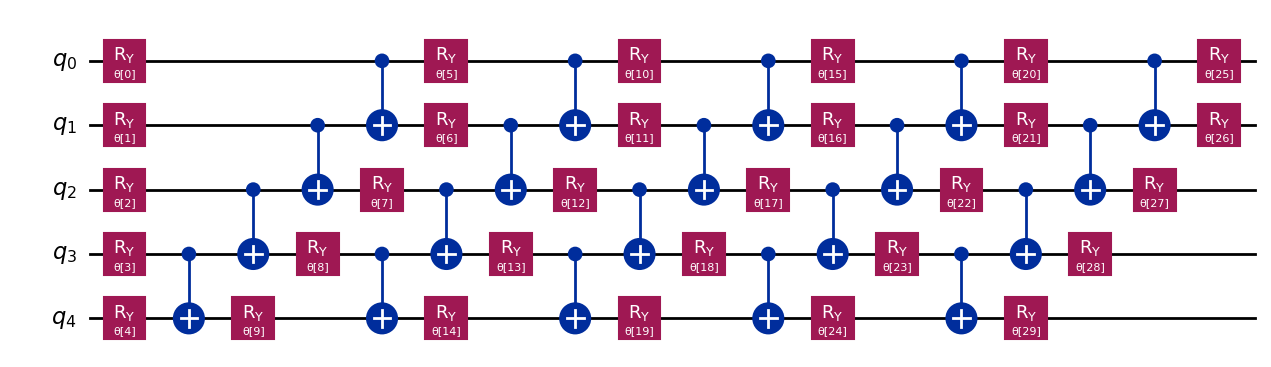

In [4]:
numqubits=5
qc=parameterized_circuit(numqubits)
qc.decompose().draw(output='mpl' )


In [42]:
!pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable


In [5]:
print(qc.data)

[CircuitInstruction(operation=Instruction(name='RealAmplitudes', num_qubits=5, num_clbits=0, params=[ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23]), ParameterVectorElement(θ[24]), ParameterVectorElement(θ[25]), ParameterVectorElement(θ[26]), ParameterVectorElement(θ[27]), ParameterVectorElement(θ[28]), ParameterV

## circuit visuvalization on what we are trying to achieve:
qin - input state ; 
qtrash - trash space ;
qref - reference state ; 
qcrtl - swap test

lization:
qin - input state
qtrash - trash space

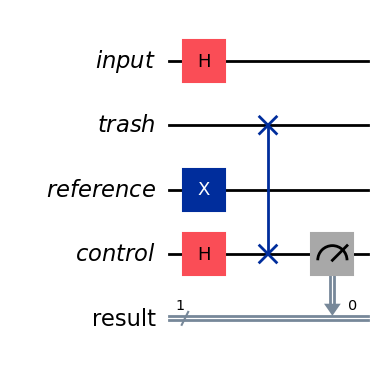

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import matplotlib.pyplot as plt

# Circuit visualization
def circuitvis():
    qin = QuantumRegister(1, 'input')
    qtrash = QuantumRegister(1, 'trash')
    qref = QuantumRegister(1, 'reference')
    qctrl = QuantumRegister(1, 'control')
    cr = ClassicalRegister(1, 'result')

    qc = QuantumCircuit(qin, qtrash, qref, qctrl, cr)

    # To establish superposition and perform operations:
    qc.h(qin[0])        # Apply Hadamard gate on the input qubit
    qc.x(qref[0])       # Set the reference qubit to |1>
    qc.h(qctrl[0])      # Apply Hadamard gate on the control qubit

    # Example operations, modify as needed
    qc.swap(qctrl[0], qtrash[0])  # Swap the control and trash qubits
    qc.measure(qctrl[0], cr[0])    # Measure the control qubit

    # Draw the circuit
    return qc.draw(output='mpl')

# Display the circuit
circuitvis()


## Encoder circuit
Latent space is used to represent the compressed information and the number of bits that will be disregarded is represented by trash space


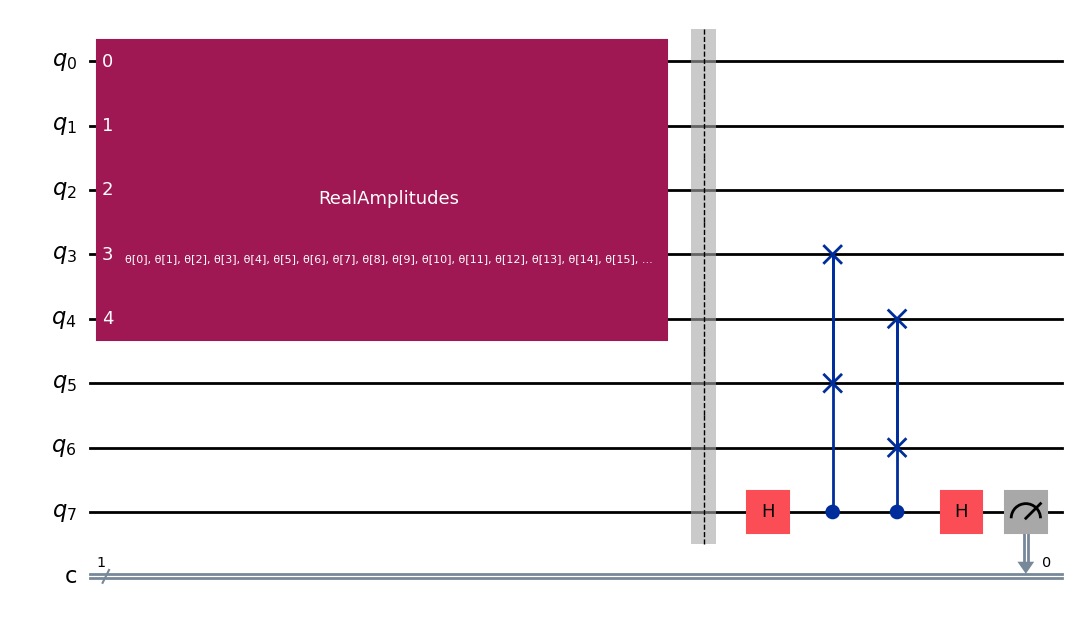

In [7]:
def encodercircuit(numlatent, numtrash):
    qr = QuantumRegister(numlatent + 2 * numtrash + 1, "q")
    cr = ClassicalRegister(1, "c")
    qc = QuantumCircuit(qr, cr)
    
    qc.compose(parameterized_circuit(numlatent + numtrash), range(numlatent + numtrash), inplace=True)
    qc.barrier()
    
    auxqbit = numlatent + 2 * numtrash
    qc.h(auxqbit)
    
    for i in range(numtrash):
        qc.cswap(auxqbit, numlatent + i, numlatent + numtrash + i)

    qc.h(auxqbit)
    qc.measure(auxqbit, cr[0])
    
    return qc

num_latent = 3
num_trash = 2
circuit = encodercircuit(num_latent, num_trash)
circuit.draw(output="mpl")


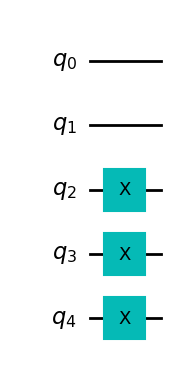

In [8]:
def domain_wall(circuit, a, b):
    
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit

domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl", style="clifford")


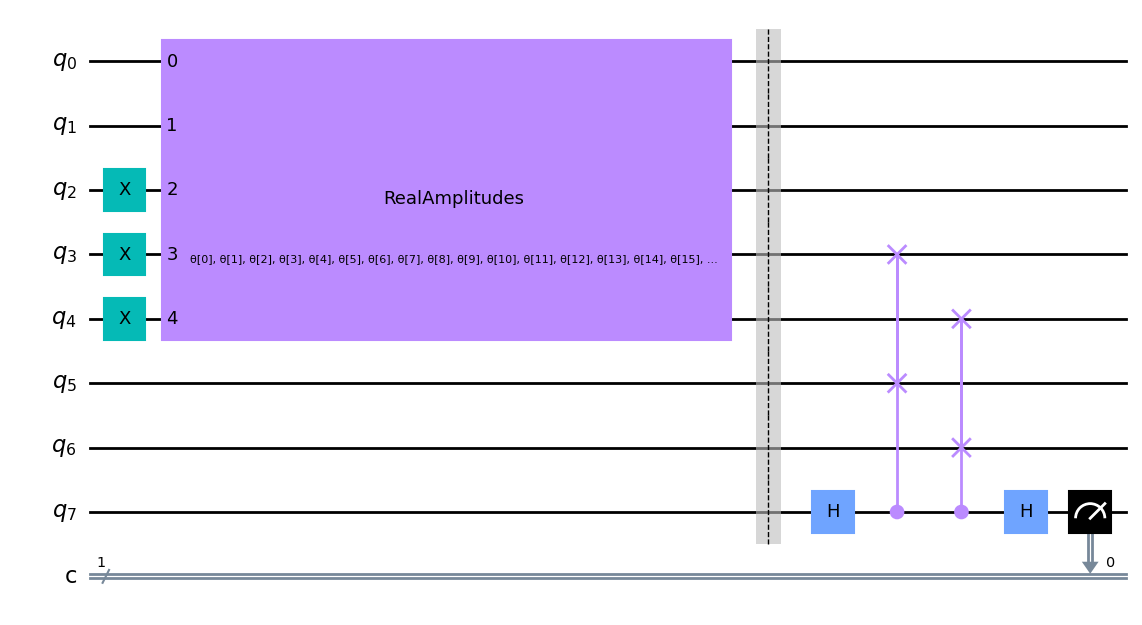

In [9]:
ae = encodercircuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw(output="mpl", style="clifford")

In [10]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [11]:
def cost_func_domain(params_values):
    #input_data = np.random.rand(1, 32)
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

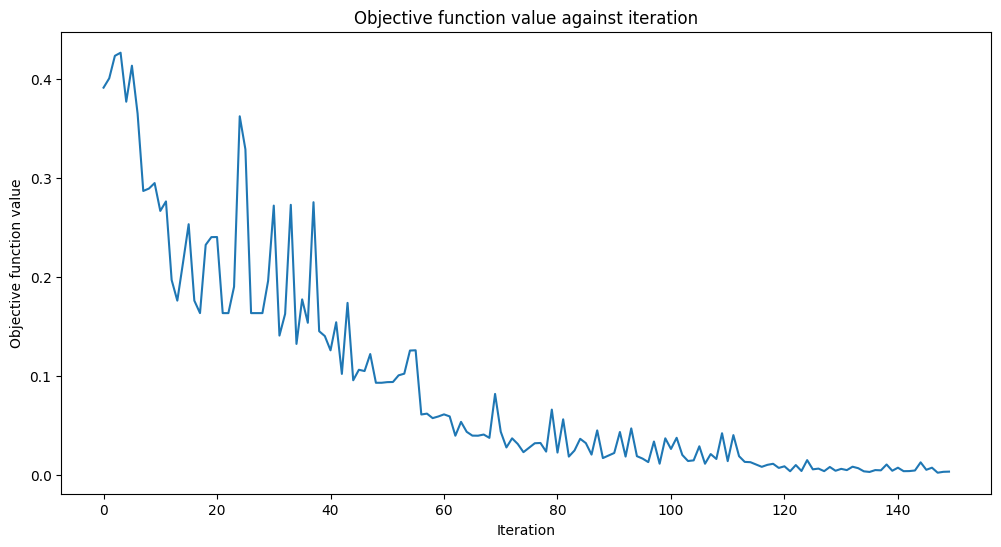

Fit in 17.05 seconds


In [12]:
from IPython.display import clear_output

import time
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

C:\Users\sarat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: C:\Users\sarat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


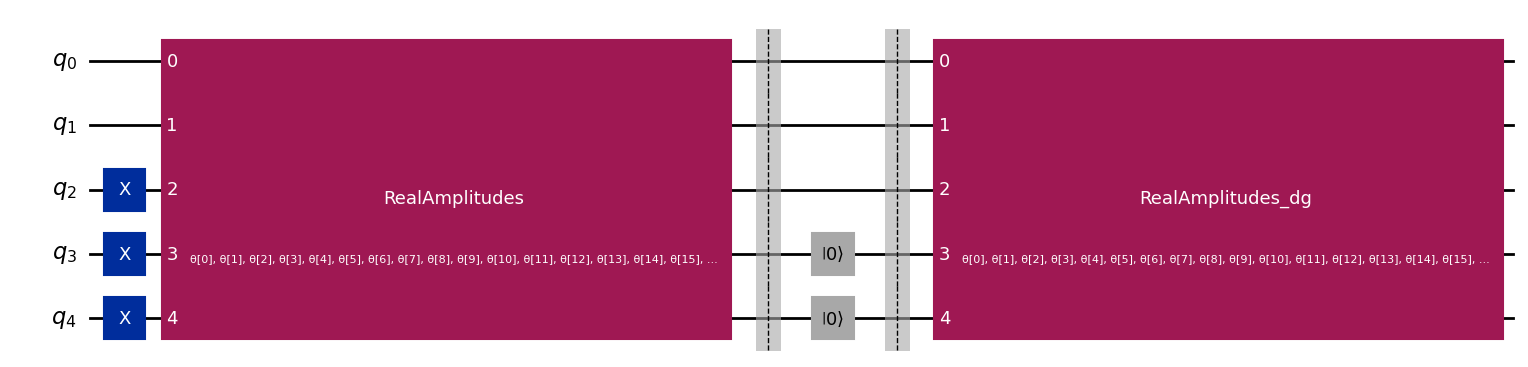

In [13]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = parameterized_circuit(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw(output="mpl", style="iqx")

In [14]:
test_qc = test_qc.assign_parameters(opt_result.x)

In [15]:
from qiskit.quantum_info import Statevector

domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity : ", fidelity.real)

Fidelity :  0.9975426052581452


In [16]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]

In [17]:
def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


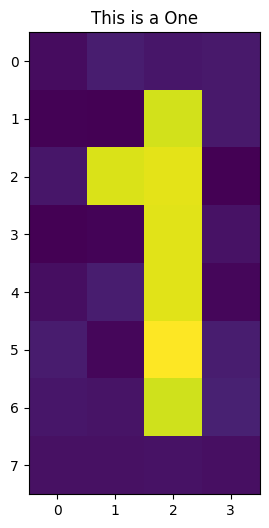

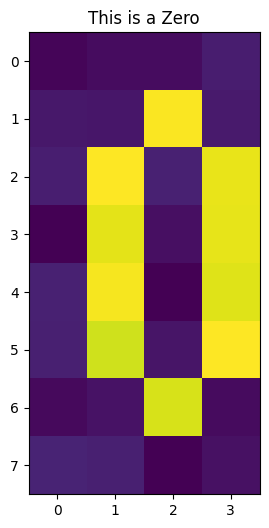

In [18]:
def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)

C:\Users\sarat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: C:\Users\sarat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


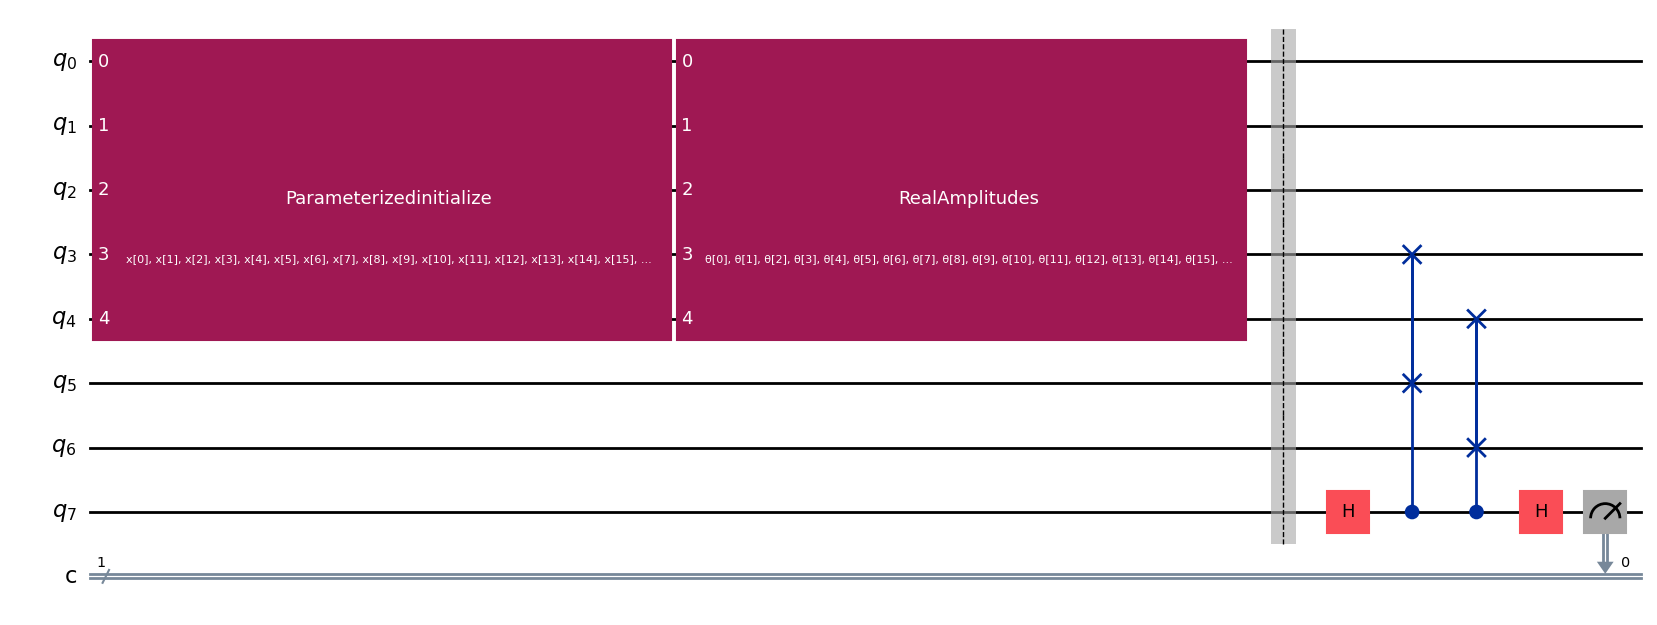

In [19]:
from qiskit_machine_learning.circuit.library import RawFeatureVector

num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = encodercircuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="iqx")

In [20]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [21]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

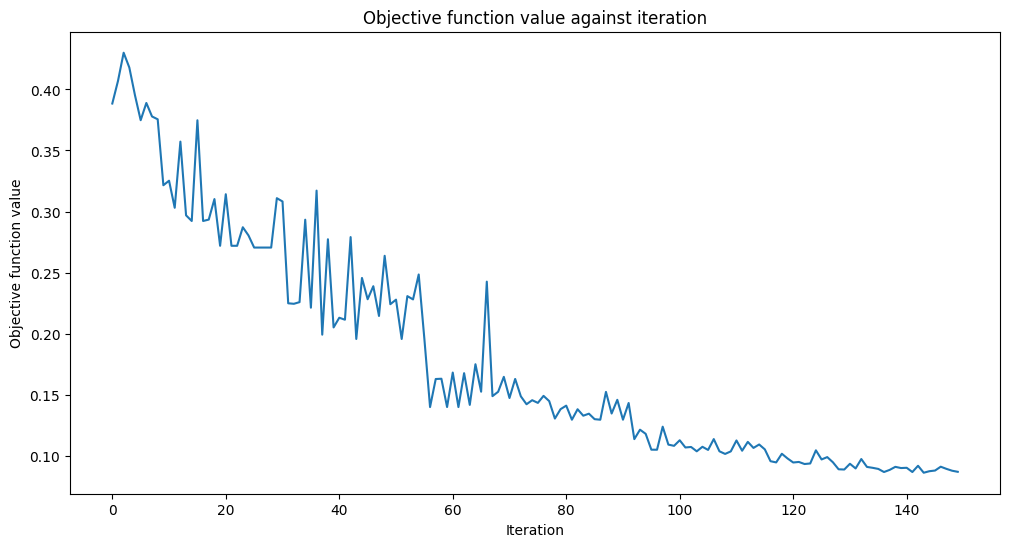

Fit in 19.44 seconds


In [22]:
opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

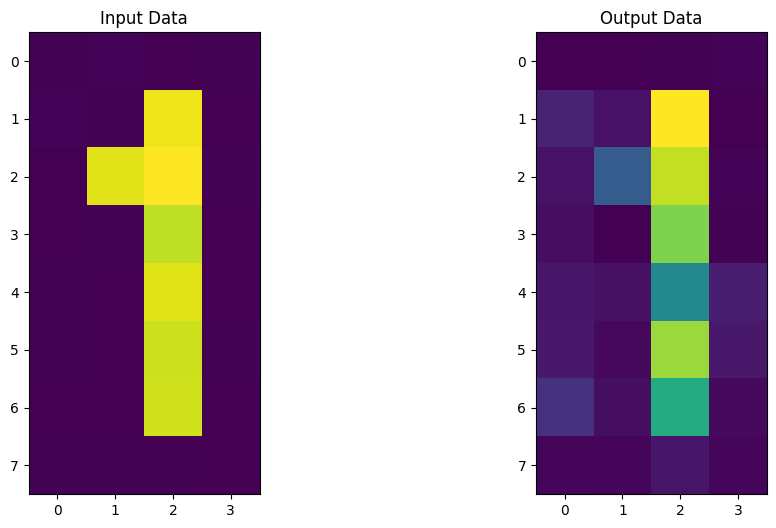

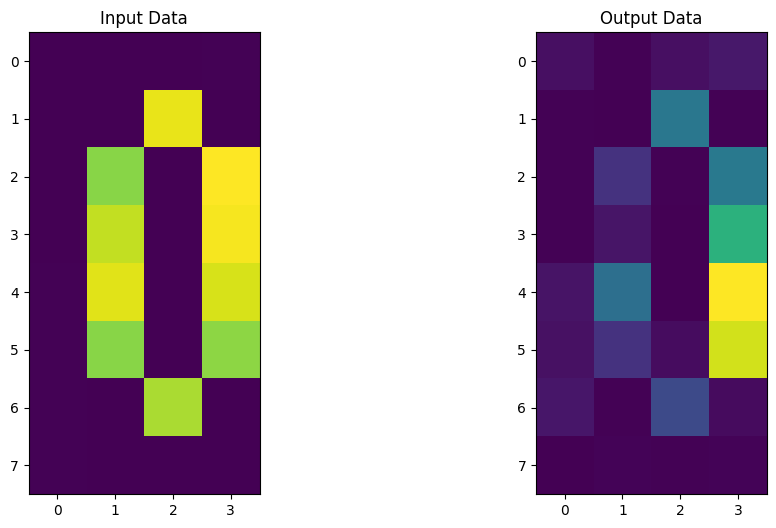

In [23]:
from qiskit.quantum_info import Statevector

test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc =parameterized_circuit(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()

In [46]:
import numpy as np
import soundfile as sf

# Parameters
sample_rate = 16000  # Sample rate in Hz
duration = 1.0       # Duration in seconds
frequency = 440.0    # Frequency of the sine wave in Hz (A4)

# Generate time axis
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate the sine wave
audio_data = 0.5 * np.sin(2 * np.pi * frequency * t)  # Amplitude scaled to 0.5

# Save to an audio file
output_audio_file = 'sine_wave_440Hz.wav'
sf.write(output_audio_file, audio_data, sample_rate)

print(f"Sine wave audio saved to {output_audio_file}")


Sine wave audio saved to sine_wave_440Hz.wav


In [47]:
import librosa
import numpy as np
import soundfile as sf
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RealAmplitudes

# Function to load audio
def load_audio(filename, sample_rate=16000, duration=1):
    audio, _ = librosa.load(filename, sr=sample_rate, duration=duration)
    return audio

# Function to create the ansatz circuit
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

# Function to create the autoencoder circuit
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    
    # Add ansatz to the circuit
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    
    auxiliary_qubit = num_latent + 2 * num_trash
    # Swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    
    return circuit

# Function to denoise audio
def denoise_audio(audio):
    return librosa.effects.preemphasis(audio)

# Load audio
audio_file = 'sine_wave_440Hz.wav'
audio = load_audio(audio_file)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=5)
features = np.mean(mfccs, axis=1)
features = features / np.linalg.norm(features)  # Normalize

# Quantum encoding (mock)
num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)

# Mocking quantum execution (substituting the measurement result)
# In an actual quantum setup, this would be handled by a quantum simulator
mock_result = { '0': 1024, '1': 512 }  # Example counts for quantum measurement results
print(f"Mock quantum measurement results: {mock_result}")

# Denoise audio
denoised_audio = denoise_audio(audio)

# Save the denoised audio to a file
output_audio_file = 'denoised_output.wav'
sf.write(output_audio_file, denoised_audio, 16000)

print(f"Denoised audio saved to {output_audio_file}")


Mock quantum measurement results: {'0': 1024, '1': 512}
Denoised audio saved to denoised_output.wav
